# The (Data) Science of Kpop:   Understanding BTS through Data and A.I.

#### Many media outlets have raised and answered their own question of what makes BTS so unique compared to other K-pop groups. Their answers, whether from Vox or Time magazine, aren't really well-supported by evidence, such as the claim that BTS is unique because of "confucian values" or "group synchrony". Fortunately, we have data science, where we can use both traditional and cutting-edge techniques to scientifically explore BTS' true uniqueness, if such a thing exists. This notebook examines two major aspect of BTS: their songs and their lyrics. As many fans have claimed that BTS' lyrics are different compared to their competitors (as well as their music), I will examine and answer these two major claims in this notebook.

<h2>$$Contents$$</h2>

* [1. Data Strategy and EDA](#$$1.\-Data\-Strategy\-and\-EDA$$)
    * [1.1 EDA](#1.1-EDA)
* [2. Modeling (Internal Data)](#$$2.\-Modeling$$)
    * [2.1 Baseline Modeling for a BTS Classifier](#2.1-Baseline-Modeling-for-a-BTS-Classifier)
    * [2.2 Feature Importance](#2.2-Feature-Importance)
    * [2.3 Feature Impact](#2.3-Feature-Impact)
* [3. Lyrics and Natural Language Processing](#$$3.\-Lyrics\-and\-Natural\-Language\-Processing$$)
    * [3.1. Doc2Vec with Gensim](#3.1-Doc2Vec-with-Gensim)
    * [3.2. Creating a BTS Classifier (Lyrics)](#3.2-Creating-a-BTS-Classifier)
    * [3.2. Latent Dirichlet Allocation](#3.2-Latent-Dirichlet-Allocation)


# $$1.\ Data\ Strategy\ and\ EDA$$

**Data Strategy:** The data strategy for this notebook is as follows:

1) Obtain the musical features of recently popular k-pop groups using Spotify's API. Parse json files in order to store these features in a workable dataframe.

2) Use BeautifulSoup to webscrape translated English lyrics of k-pop songs from these groups. The lyrics will be used for Natural Language Processing and building k-pop classifier using texts.

3) Code for tapping into Spotify API and scraping the web will be stored in a separate python file.

**4) Important: I will take a one-vs.-all approach. As, our target label will be 1 if BTS and 0 if any other group. This will allow for binary classification when building a classifier.**


__Load Modules and CSV__

In [57]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dask.dataframe as dd
import seaborn as sns


plt.style.use('ggplot')

from seaborn import distplot
import seaborn as sns
from pandas.tools.plotting import scatter_matrix

import warnings
warnings.filterwarnings('ignore')

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

import string
import re
from imblearn.over_sampling import SMOTE

from sklearn.metrics import *
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from catboost import CatBoostClassifier, Pool, cv
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn.ensemble.partial_dependence import partial_dependence
import shap
from itertools import combinations

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis

import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)


%pylab inline


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib


In [38]:
kpop_df = pd.read_csv('data/musical_data/merged_kpop_song_features.csv', index_col = 0)

In [39]:
kpop_df['release_date'] = pd.to_datetime(kpop_df['release_date'])
kpop_df['year'] = [i.year for i in kpop_df.release_date]
kpop_df['artist_name'] = [i.lower().replace("'", '') for i in kpop_df.artist_name]

>Extracting the year allows us to analyze evolving musical trends by year

## 1.1 EDA

#### High-level data analysis: correlation, seasonality, and distributions.

In [ ]:
kpop_df.head(6)

Audio Features meaning:

"acousticness": A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.

"danceability": Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.

"energy": Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale.

"instrumentalness": Predicts whether a track contains no vocals. “Ooh” and “aah” sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly “vocal”. The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. 

"liveness": Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.

"loudness": The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. 

"speechiness": Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words

"valence": A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).

In [ ]:
kpop_df.artist_name.value_counts()

In [107]:
# Again, I will do a one-v-all approach. As such, our target label will be 1 if BTS and 0 if any other group
kpop_df['target'] = [1 if i == 'bts' else 0 for i in kpop_df.artist_name]

In [108]:
kpop_df.corr()['target'].sort_values()

liveness           -0.199258
acousticness       -0.090075
danceability       -0.070142
instrumentalness   -0.062143
time_signature     -0.045011
tempo              -0.013214
energy             -0.010801
valence             0.004409
key                 0.018999
duration_ms         0.025215
year                0.147708
speechiness         0.326600
target              1.000000
Name: target, dtype: float64

>Speechiness and liveness have strong linear relationship with the target variable. We see that speechiness is positively correlated with the target, meaning that as speechiness increases, so does the target variable: being a BTS over being other k-pop groups. Let's just focus on those two features to visualize possible structured relationships between them.

In [109]:
kpop_df.groupby('artist_name').agg({'speechiness':'mean', 'instrumentalness':'mean', 'danceability':'mean', 'energy':'mean','acousticness':'mean', 'valence':'mean'}).sort_values('speechiness', ascending = False)

,speechiness,instrumentalness,danceability,energy,acousticness,valence
artist_name,,,,,,
bts,0.172844,0.012400,0.601454,0.801566,0.118142,0.547792
bigbang,0.108219,0.006586,0.582627,0.832900,0.109640,0.439794
red velvet,0.094951,0.017682,0.668874,0.748158,0.224725,0.627593
wanna one,0.094881,0.000000,0.616815,0.787222,0.199652,0.551296
ikon,0.093867,0.028128,0.630211,0.796621,0.191380,0.517419
shinee,0.083504,0.014346,0.637085,0.807092,0.143948,0.586216
aoa,0.073649,0.098046,0.665081,0.847846,0.159874,0.716894
girls generation,0.072917,0.052389,0.670790,0.797883,0.228858,0.646900
gfriend,0.054407,0.289859,0.617545,0.719066,0.253075,0.530064


>Notice that BTS' songs are the "speechiest" on average by far, almost doubling or tripling songs by other k-pop groups.

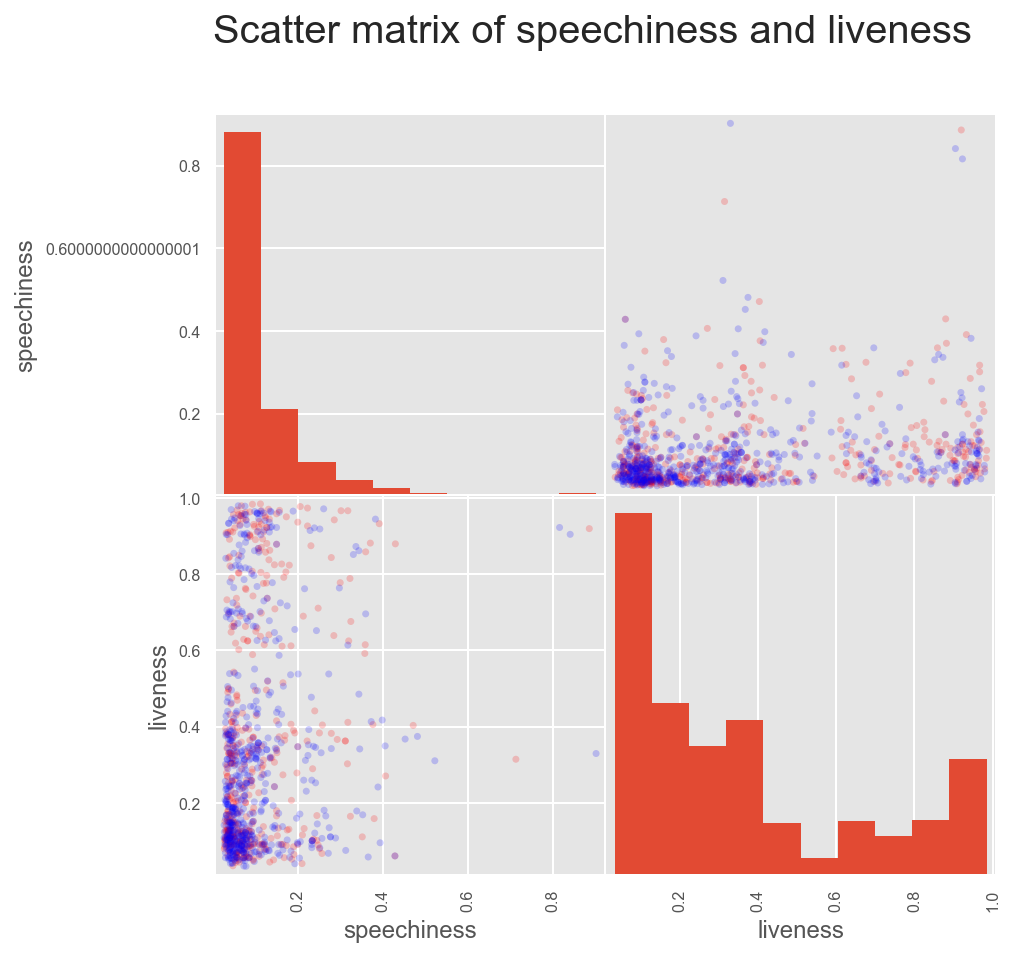

In [110]:
colors = ['red' if ix else 'blue' for ix in kpop_df.target]

scatter_matrix(kpop_df[['speechiness', 'liveness']].sample(1000), alpha = 0.2, figsize = (7,7), diagonal = 'hist', color = colors);
suptitle('Scatter matrix of speechiness and liveness', size = 20);

>The scatter matrix shows that the lower the speechiness, the lower the liveness. The red dots reflect individual BTS songs and the blue dots represent songs from other k-pop groups. Unlike previous analysis through tables, we can't really find the discernment between two target labels through visualization.

#### Focusing specifically on BTS vis-a-vis other k-pop groups

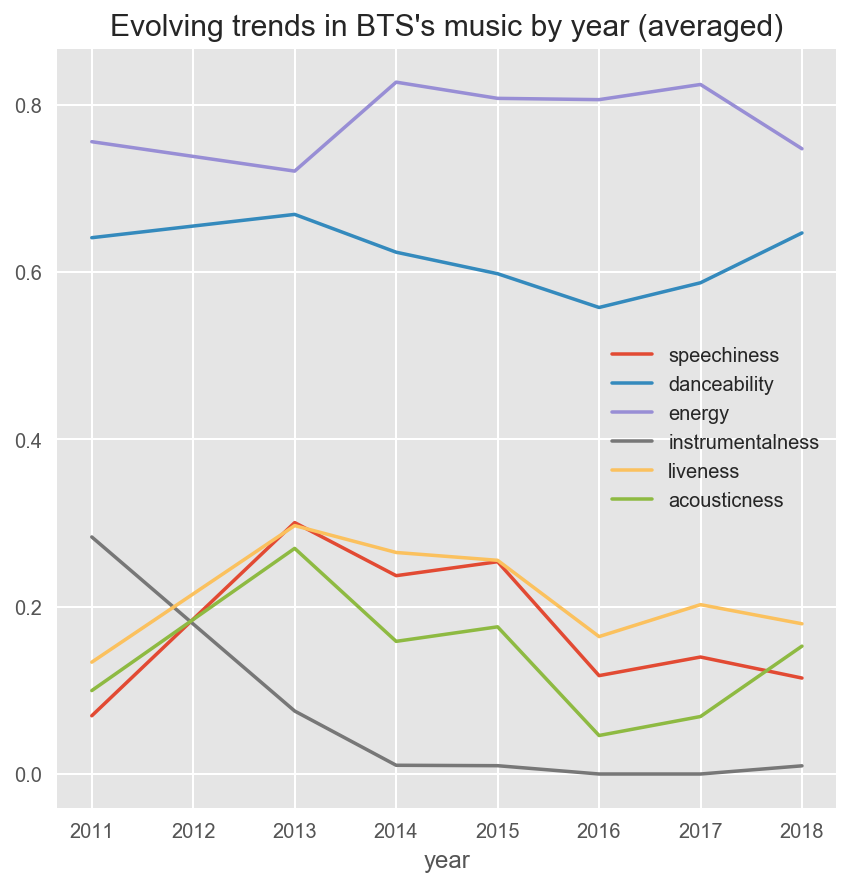

In [111]:
bts_grouped = kpop_df[kpop_df.artist_name == 'bts']
bts_grouped.groupby('year').agg({'speechiness':'mean', 'danceability':'mean', 'energy':'mean', 'instrumentalness':'mean', 'liveness':'mean', 'acousticness':'mean'}).plot(figsize = (7,7));
title('Evolving trends in BTS\'s music by year (averaged)', size = 15);

>Over the years, BTS music has become less and less instrumental to the point where their music no longer has instrumental sounds. This makes sense, since we've seen that BTS' songs have a lot of vocal presence (speechiness), which is inverse to instrumentalness, where "the greater likelihood the track contains no vocal content". Let us see the distribution of all of their features.

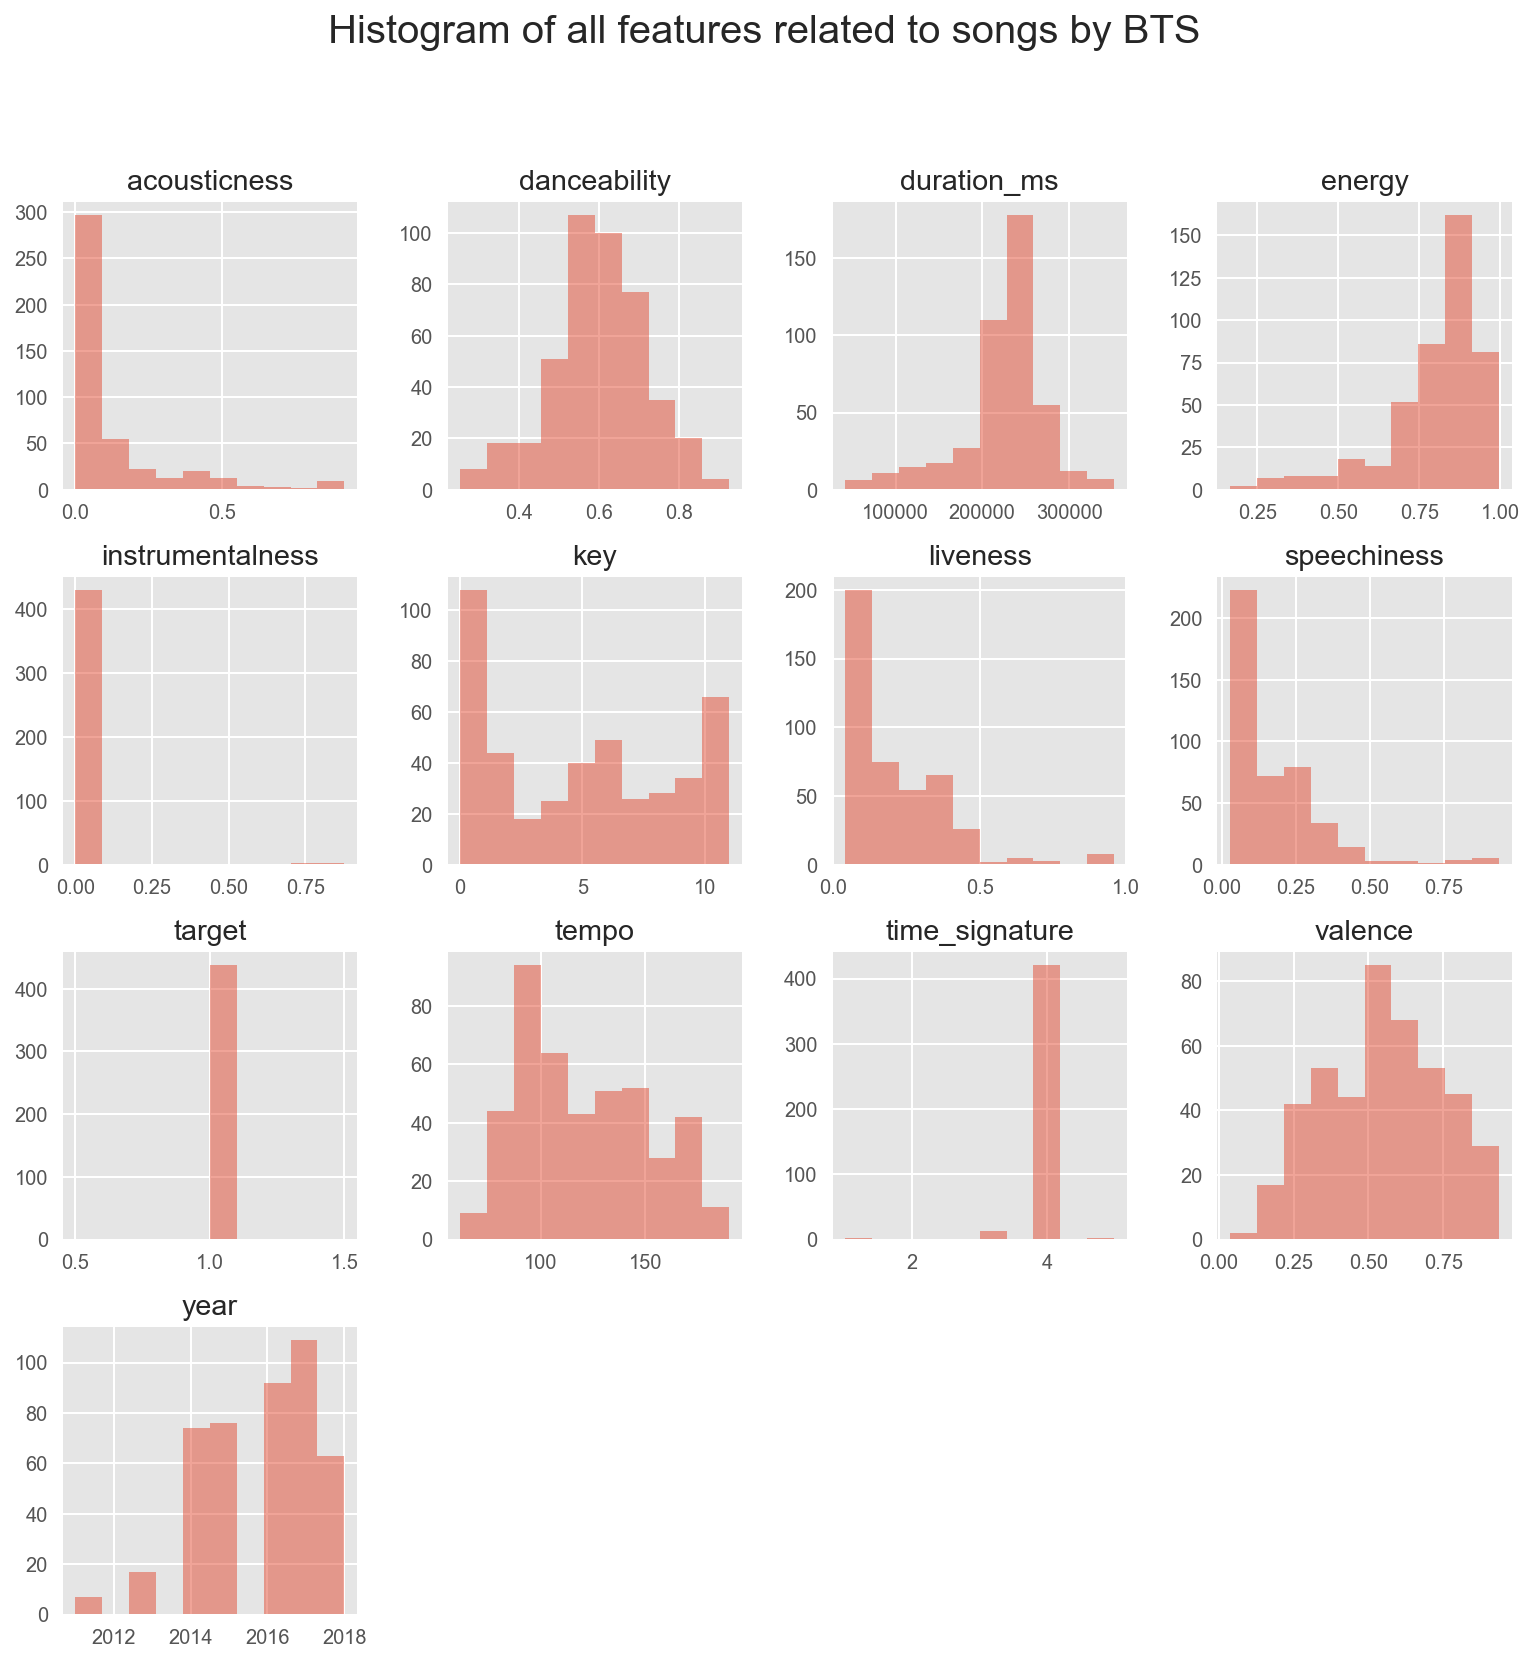

In [112]:
figure = figsize(13,13)
kpop_df[kpop_df.artist_name == 'bts']._get_numeric_data().hist(alpha = 0.5);
suptitle('Histogram of all features related to songs by BTS', size = 20);

These simple histrograms displays important musical qualities: 

1) BTS has been generally producing more music each year. 

2) Their songs are generally well-balanced in valenece (happiness/saddness of a song), tempo, and danceability. 

3) They are low in acousticness, high in energy. Speechiness is interesting here, where on average, the number is high, but in terms of the count, most songs are actually quite lower on the speechiness side. 

In [113]:
bts_tempo = kpop_df[kpop_df['artist_name'] == 'bts']['tempo']  
bigbang_tempo = kpop_df[kpop_df['artist_name'] == 'bigbang']['tempo']  
ikon_tempo = kpop_df[kpop_df['artist_name'] == 'ikon']['tempo']  

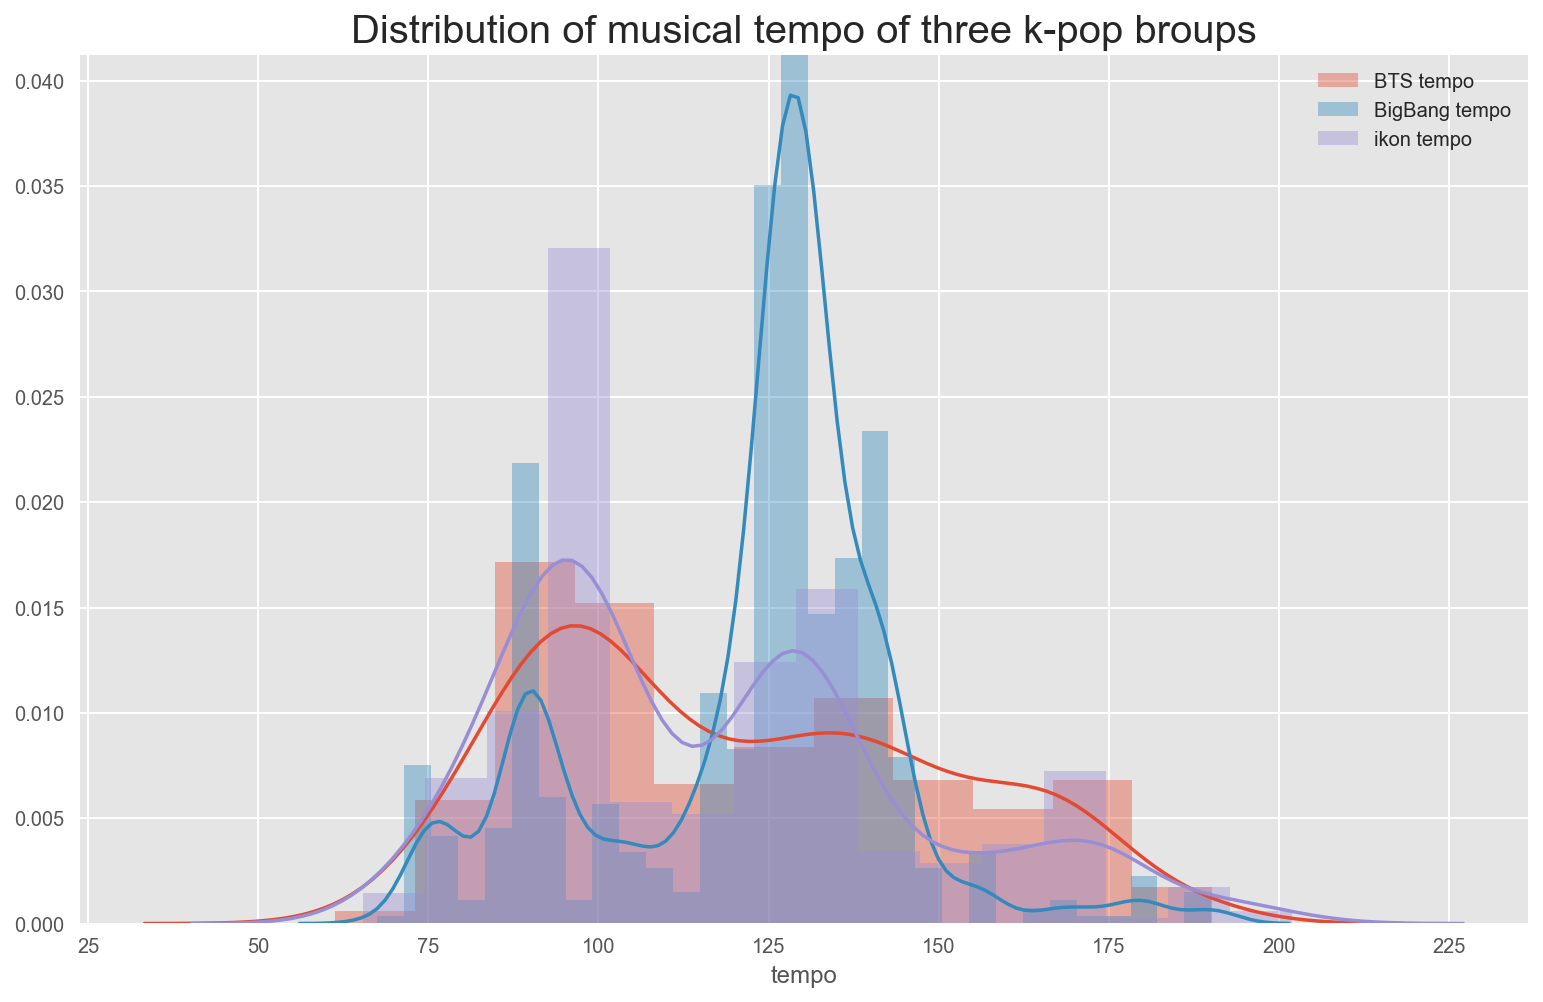

In [114]:
figure = figsize(13,8)
sns.distplot(bts_tempo, label = 'BTS tempo');
sns.distplot(bigbang_tempo, label = 'BigBang tempo');
sns.distplot(ikon_tempo, label = 'ikon tempo');
title('Distribution of musical tempo of three k-pop broups', size = 20)
legend();

>Visualization makes difference between groups all the more transparent. We see that while Big Bang's songs are mostly centered in a tempo of 125 and ikon's songs are centered around 90, BTS's songs are far more diverse and distributed. 

# $$2.\ Modeling$$

## 2.1 Baseline Modeling for a BTS Classifier

A simple baseline model is a good practice to determine a baseline score to improve upon.

I will choose three popular (tree-based) boosting algorithms.

- LIghtGBM Classifier 
- Gradientboost Classifier
- RandomForest Classifier

I will also use a oversampling technique (**SMOTE**) to address the class imbalance issue.

In [4]:
from sklearn.metrics import *
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from catboost import CatBoostClassifier, Pool, cv
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn.ensemble.partial_dependence import partial_dependence
import shap
from itertools import combinations


In [16]:
kpop_df.head()

,danceability,energy,key,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,artist_name,release_date,song_name,song_name_formatted,year,target
0,0.637,0.799,2,0.0338,0.3940,0.0,0.0921,0.562,104.995,228615,4,bts,2018-08-24,Euphoria,euphoria,2018,1
1,0.723,0.906,1,0.2790,0.0907,0.0,0.0771,0.398,125.019,225221,4,bts,2018-08-24,Trivia 起 : Just Dance,trivia-just-dance,2018,1
2,0.347,0.578,8,0.0626,0.4450,0.0,0.2310,0.226,86.730,276708,5,bts,2018-08-24,Serendipity (Full Length Edition),serendipity-length,2018,1
3,0.599,0.774,1,0.0541,0.0223,0.0,0.0669,0.696,129.819,223123,4,bts,2018-08-24,DNA,dna,2018,1
4,0.612,0.844,5,0.0756,0.1420,0.0,0.2870,0.653,134.868,196776,4,bts,2018-08-24,Dimple,dimple,2018,1


In [17]:
kpop_df_copy = kpop_df.copy()
kpop_df = kpop_df.drop(['artist_name','release_date','year','song_name','song_name_formatted'], 1)

In [18]:
X_train, X_validation, y_train, y_validation = train_test_split(kpop_df.iloc[:,:-1], kpop_df.target, train_size=0.2)

X_train_lgbm = pd.get_dummies(X_train)
X_validation_lgbm = pd.get_dummies(X_validation)

X_train_lgbm.reset_index(inplace = True)
X_validation_lgbm.reset_index(inplace = True)

In [19]:
sm = SMOTE()

X_train_smote, y_train_smote = sm.fit_sample(X_train_lgbm, y_train.ravel())
X_validation_smote, y_validation_smote = sm.fit_sample(X_validation_lgbm, y_validation.ravel())

X_train_smote = pd.DataFrame(X_train_smote, columns = X_train_lgbm.columns).set_index('index')
X_validation_smote = pd.DataFrame(X_validation_smote, columns = X_validation_lgbm.columns).set_index('index')

In [19]:
lgb_c = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary', 
                                   class_weight = 'balanced', learning_rate = 0.01,
                                   reg_alpha = 0.1, reg_lambda = 0.1, silent=True,
                                   subsample = 0.8, n_jobs = -1, random_state = 50)
lgb_c.fit(X_train_smote, y_train_smote,
           eval_set=[(X_validation_smote, y_validation_smote)],
           early_stopping_rounds=100,
eval_metric='auc',
verbose=200,)


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's binary_logloss: 0.395025	valid_0's auc: 0.923992
[400]	valid_0's binary_logloss: 0.349566	valid_0's auc: 0.936627
[600]	valid_0's binary_logloss: 0.350522	valid_0's auc: 0.940678
Early stopping, best iteration is:
[517]	valid_0's binary_logloss: 0.34776	valid_0's auc: 0.939255


LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
        colsample_bytree=1.0, importance_type='split', learning_rate=0.01,
        max_depth=-1, min_child_samples=20, min_child_weight=0.001,
        min_split_gain=0.0, n_estimators=10000, n_jobs=-1, num_leaves=31,
        objective='binary', random_state=50, reg_alpha=0.1, reg_lambda=0.1,
        silent=True, subsample=0.8, subsample_for_bin=200000,
        subsample_freq=0)

In [20]:
gbc = GradientBoostingClassifier(n_estimators=1000, learning_rate=0.01)
gbc.fit(X_train_smote, y_train_smote)

validation_pred_proba_grad = gbc.predict_proba(X_validation_smote)
roc_auc_score(y_validation_smote, validation_pred_proba_grad[:,1])

0.9326544139165975

In [21]:
rf = RandomForestClassifier()
rf.fit(X_train_smote,y_train_smote)

validation_pred_proba_grad = rf.predict_proba(X_validation_smote)
roc_auc_score(y_validation_smote, validation_pred_proba_grad[:,1])

0.9115468177241185

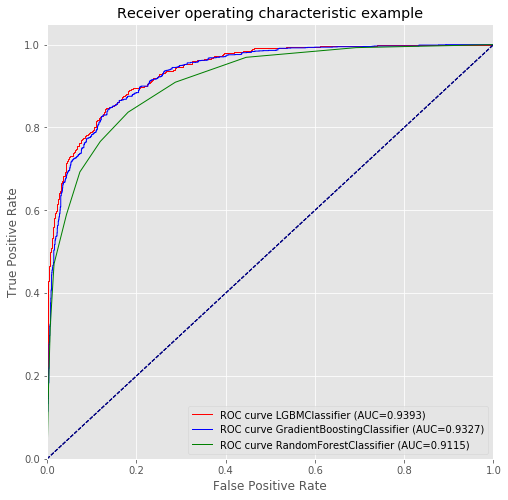

In [22]:
def plot_roc(model, X_validation, y_validation,  color):
    validation_pred_proba = model.predict_proba(X_validation)
    fpr, tpr, thresholds = roc_curve(y_validation, validation_pred_proba[:,1])
    auc = roc_auc_score(y_validation, validation_pred_proba[:,1])

    plt.plot(fpr, tpr, color=color,lw=1, label='ROC curve {} (AUC={:0.4f})'.format(model.__class__.__name__,auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right");
    
figure = figsize(8,8)
plot_roc(lgb_c, X_validation_smote, y_validation_smote, 'r')
plot_roc(gbc, X_validation_smote, y_validation_smote, 'b')
plot_roc(rf, X_validation_smote, y_validation_smote, 'g')

>Each model is performing phenomenally in terms of AUC score. LGBM performs the best, even though this and every other model has not been optimized. I suspect this has to do with the deterministic aspect of the data, meaning it's not prone to randomness and stochatisticity usually seen in data related to user/consumer behaviors.

## 2.2 Feature Importance

Feature Importance is a traditional algorithm that tells us which features are most important across the entire data. It is therefore called a __global interpretation__ that measures "global" trends, rather than local ones -- the latter of which will be discussed later.

- LGBMClassifier

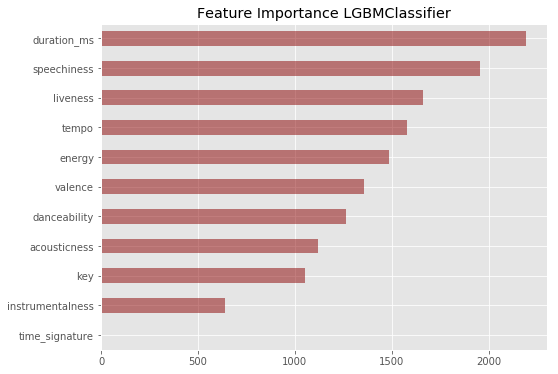

In [23]:
importance_series = pd.Series(data=lgb_c.feature_importances_, index=X_validation_smote.columns)
ax = importance_series.sort_values().plot(kind='barh',width=0.5, figsize=(8,6), color='darkred', alpha=0.5)
ax.set_title('Feature Importance LGBMClassifier');

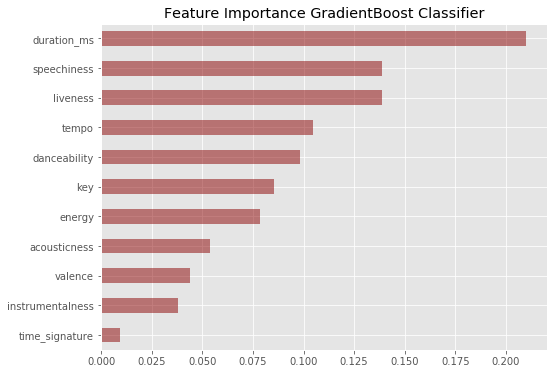

In [24]:
importance_series = pd.Series(data=gbc.feature_importances_, index=X_validation_smote.columns)
ax = importance_series.sort_values().plot(kind='barh',width=0.5, figsize=(8,6), color='darkred', alpha=0.5)
ax.set_title('Feature Importance GradientBoost Classifier');

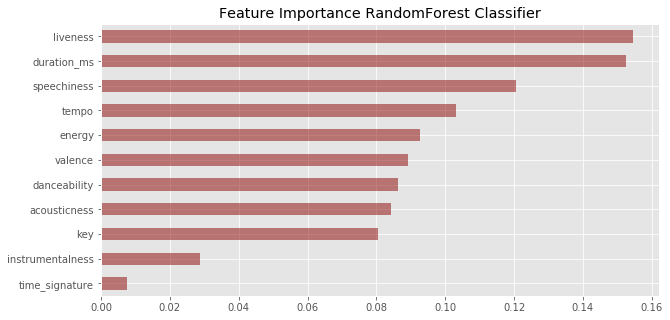

In [25]:
importance_series = pd.Series(data=rf.feature_importances_, index=X_validation_smote.columns)
ax = importance_series.sort_values().plot(kind='barh',width=0.5, figsize=(10,5), color='darkred', alpha=0.5)
ax.set_title('Feature Importance RandomForest Classifier');

Feature Importance is a good initial way of measuring feature importance. But there are many problems with this measurement, which I won't go into here. Due to several issues of feature importance, many other metrics have been invented, which I term Feature Impact.

- The Feature Impact of _LightGBMClassifier_ on model output. I base Feature Impact partly on the SHAP values, based on the Shapley value that calculates how much each feature individually contributes to the final prediction, negatively or positively. One huge advantage of SHAP values is their local interpretability, meaning that each individual in our data is also assigned with his/her own SHAP value, allowing analysis on a 'local' level. The charts below will clarify what this means.

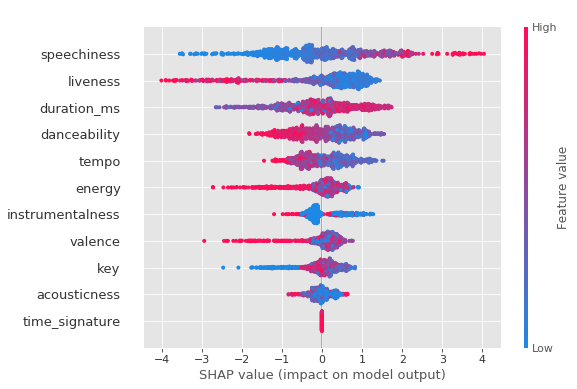

In [27]:
explainer = shap.TreeExplainer(lgb_c)
shap_values = explainer.shap_values(X_train_smote)

shap.summary_plot(shap_values, X_train_smote)

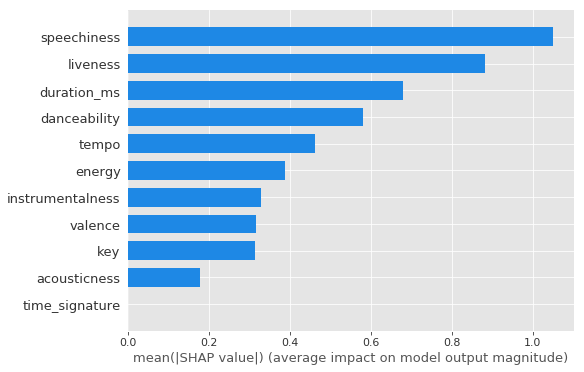

In [28]:
shap.summary_plot(shap_values, X_train_smote, plot_type = "bar")

# $$3.\ Lyrics\ and\ Natural\ Language \ Processing$$

__Load and Clean Textual Data__

In [28]:
# Data I have already cleaned the data using strip_meta_text and other functions. I will also pursue a one-v-all approach here.

all_lyrics = pd.read_csv('data/lyrics_data/Korean_lyrics/merged_original_kpop_lyrics.csv', index_col = 0)

In [15]:
# meta text are things like "(Verse One)" and other texts that aren't part of the lyrics. 
def strip_meta_text(s):
    for i in range(len(s)):
        j = i +1
        try:
            if s[i] == "[":
                while s[j] != "]":
                    j+=1
                s = s.replace(s[i:j +1], '')
            elif s[i] == "(":
                while s[j] != ")":
                    j+=1
                s = s.replace(s[i:j +1], '')
        except Exception as e:
            pass
    return s


In [24]:
### These functions were used to clean and created the merged data. No longer necessary.

# all_lyrics.columns = ['name','text','target']

# all_lyrics['text'] = all_lyrics['text'].apply(lambda x: x.lower().replace('\n',' '))
# all_lyrics['text'] = all_lyrics['text'].apply(lambda x: strip_meta_text(x))

# pd.set_option('display.max_colwidth', 0)

# all_lyrics['indices'] = range(all_lyrics.shape[0])
# all_lyrics.set_index('indices', 1, inplace = True)

# all_lyrics['text'] = all_lyrics['text'].apply(lambda x:''.join([i for i in x if i not in string.punctuation]))

In [23]:
# all_lyrics.to_csv('lyrics_data/lyrics.txt')
# all_lyrics.to_csv('lyrics_data/all_lyrics.csv')

## 3.1 Doc2Vec with Gensim

Gensim's module provides a handy Word2Vec and Doc2Vec for word embeddings

In [29]:
# gensim modules
import gensim
from gensim import utils
from gensim.models.doc2vec import LabeledSentence
from gensim.models import Doc2Vec, Word2Vec

# numpy
import numpy

# classifier
from sklearn.linear_model import LogisticRegression

# random
import random

In [30]:
# Tweaking the LabeledLineSentence class to allow separation of labels and a list of words for multiple files

class LabeledLineSentence(object):
    def __init__(self, sources):
        self.sources = sources
        
        flipped = {}
        
        # make sure that keys are unique
        for key, value in sources.items():
            if value not in flipped:
                flipped[value] = [key]
            else:
                raise Exception('Non-unique prefix encountered')
    
    def __iter__(self):
        for source, prefix in self.sources.items():
            with utils.smart_open(source) as fin:
                for item_no, line in enumerate(fin):
                    yield LabeledSentence(utils.to_unicode(line).split(), [prefix + '_%s' % item_no])
    
    def to_array(self):
        self.sentences = []
        for source, prefix in self.sources.items():
            with utils.smart_open(source) as fin:
                for item_no, line in enumerate(fin):
                    self.sentences.append(LabeledSentence(utils.to_unicode(line).split(), [prefix + '_%s' % item_no]))
        return self.sentences
    
    def sentences_perm(self):
        shuffled = list(self.sentences)
        random.shuffle(shuffled)
        return shuffled

In [31]:
sources = {'data/lyrics_data/Korean_lyrics/korean_lyrics.txt':'kpop_lyrics'}

sentences = LabeledLineSentence(sources)

In [32]:
doc_model = Doc2Vec(min_count=1, window=10, size=150, sample=1e-4, negative=5, workers=7)

doc_model.build_vocab(sentences.to_array())
 
# doc_model.train(sentences.sentences_perm(), total_examples=doc_model.corpus_count, epochs= 2000)

# doc_model.save('data/doc2vecmodel')

gensim_model = gensim.models.Doc2Vec.load('data/korean_doc2vecmodel')

print(gensim_model.docvecs.most_similar(1))

[('kpop_lyrics_95', 0.6406261920928955), ('kpop_lyrics_277', 0.628616452217102), ('kpop_lyrics_90', 0.6270997524261475), ('kpop_lyrics_205', 0.6229199171066284), ('kpop_lyrics_73', 0.6170247793197632), ('kpop_lyrics_233', 0.6130409240722656), ('kpop_lyrics_108', 0.6108198165893555), ('kpop_lyrics_271', 0.6069984436035156), ('kpop_lyrics_194', 0.6055890917778015), ('kpop_lyrics_239', 0.6055294275283813)]


## 3.2 Creating a BTS Classifier

In [33]:
train_arrays = np.zeros((all_lyrics.shape[0], gensim_model['kpop_lyrics_0'].shape[0]))
train_labels = np.array(all_lyrics.target)

for i in range(all_lyrics.text.shape[0]):
    train_arrays[i] = gensim_model['kpop_lyrics_' + str(i)]

In [40]:
x_train, x_test, y_train, y_test = train_test_split(train_arrays, train_labels, test_size = .2, random_state = 40)    

In [41]:
classifier = LogisticRegression()

classifier.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [42]:
y_pred = classifier.predict(x_test)

accuracy_score(y_test,y_pred)

0.847457627118644

In [43]:
lgb_model = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary', 
                                   class_weight = 'balanced', learning_rate = 0.01,
                                   reg_alpha = 0.1, reg_lambda = 0.1, silent=True,
                                   subsample = 0.8, n_jobs = -1)
lgb_model.fit(x_train, y_train,
           eval_set=[(x_test, y_test)],
           early_stopping_rounds=10000,
eval_metric='auc',
verbose=200,)

Training until validation scores don't improve for 10000 rounds.
[200]	valid_0's binary_logloss: 0.455936	valid_0's auc: 0.856105
[400]	valid_0's binary_logloss: 0.359078	valid_0's auc: 0.911337
[600]	valid_0's binary_logloss: 0.329251	valid_0's auc: 0.925872
[800]	valid_0's binary_logloss: 0.326585	valid_0's auc: 0.93314
[1000]	valid_0's binary_logloss: 0.326253	valid_0's auc: 0.9375
[1200]	valid_0's binary_logloss: 0.324044	valid_0's auc: 0.940407
[1400]	valid_0's binary_logloss: 0.321768	valid_0's auc: 0.946221
[1600]	valid_0's binary_logloss: 0.319158	valid_0's auc: 0.947674
[1800]	valid_0's binary_logloss: 0.320406	valid_0's auc: 0.949128
[2000]	valid_0's binary_logloss: 0.320279	valid_0's auc: 0.950581
[2200]	valid_0's binary_logloss: 0.320504	valid_0's auc: 0.950581
[2400]	valid_0's binary_logloss: 0.320504	valid_0's auc: 0.950581
[2600]	valid_0's binary_logloss: 0.320504	valid_0's auc: 0.950581
[2800]	valid_0's binary_logloss: 0.320504	valid_0's auc: 0.950581
[3000]	valid_0's b

LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
        colsample_bytree=1.0, importance_type='split', learning_rate=0.01,
        max_depth=-1, min_child_samples=20, min_child_weight=0.001,
        min_split_gain=0.0, n_estimators=10000, n_jobs=-1, num_leaves=31,
        objective='binary', random_state=None, reg_alpha=0.1,
        reg_lambda=0.1, silent=True, subsample=0.8,
        subsample_for_bin=200000, subsample_freq=0)

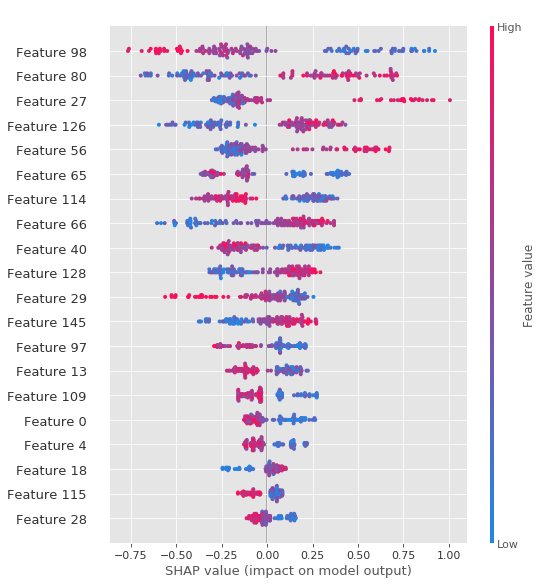

In [51]:
shap_explainer = shap.TreeExplainer(lgb_model)
shap_values = shap_explainer.shap_values(x_train)

shap.summary_plot(shap_values, x_train)

>Doesn't mean anything, since doc2vec's features aren't interpretable. 

## 3.2 Latent Dirichlet Allocation 

Latent Dirichlet Allocation (LDA) is an NLP technique for topical modeling, or extracting themes/topics in a document. LDA will be used to answer the question: __are BTS lyrics really that unique compared to other k-pop lyrics?__ This is a claim made by many BTS fans, which LDA can help us address.

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from yellowbrick.text import TSNEVisualizer
from sklearn.manifold import TSNE

In [47]:
text_corpus = all_lyrics.text.values.tolist()
text_corpus = [re.sub('\S*@\S*\s?', '', doc) for doc in text_corpus] #removing email addresses
text_corpus = [re.sub('\s+', ' ', doc) for doc in text_corpus] #removing newline characters
text_corpus = [re.sub("\'", "", doc) for doc in text_corpus] #removing single quote characters


In [85]:
#Tokenizing words

warnings.simplefilter("ignore", DeprecationWarning)

def doc_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

words = list(doc_to_words(text_corpus))



# Removing stopwords

from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
 
def remove_stopwords(text):
    return [[word for word in gensim.utils.simple_preprocess(str(doc)) if word not in stop_words] for doc in text_corpus]
 
words = remove_stopwords(words)



# lemmatizing words

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
 
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for idx, sent in enumerate(texts):
        if (idx) % 500 == 0:
            print(str(idx) + ' documents lemmatised')
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out
 
data_lemmatized = lemmatization(words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

0 documents lemmatised


In [86]:
# Creating dictionary and the corpus for gensim's built-in LDA model

import gensim.corpora as corpora
id2word = corpora.Dictionary(data_lemmatized)
 
# Create Corpus
corpus = [id2word.doc2bow(text) for text in data_lemmatized]
 
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           per_word_topics=True)

In [55]:
# def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
#     """
#     Compute c_v coherence for various number of topics

#     Parameters:
#     ----------
#     dictionary : Gensim dictionary
#     corpus : Gensim corpus
#     texts : List of input texts
#     limit : Max num of topics

#     Returns:
#     -------
#     model_list : List of LDA topic models
#     coherence_values : Coherence values corresponding to the LDA model with respective number of topics
#     """
#     coherence_values = []
#     model_list = []
#     for num_topics in range(start, limit, step):
#         lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
#                                            id2word=id2word,
#                                            num_topics=20, 
#                                            per_word_topics=True)
#         model_list.append(lda_model)
#         coherencemodel = CoherenceModel(model= lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
#         coherence_values.append(coherencemodel.get_coherence())

#     return model_list, coherence_values


# # Can take a long time to run.
# model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)
# # Show graph
# limit=40; start=2; step=6;
# x = range(start, limit, step)
# plt.plot(x, coherence_values)
# plt.xlabel("Num Topics")
# plt.ylabel("Coherence score")
# plt.legend(("coherence_values"), loc='best')
# plt.show()

>We compute the coherence scores to find the optimal number of topics. I will not run it here due to time it takes to run. I will create 10 topics to search for.

In [87]:
doc_lda = lda_model[corpus]

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.042677 -0.081537  1       1        13.877347
7      0.084232 -0.016408  2       1        12.737565
5      0.065941  0.033296  3       1        12.397749
4     -0.052097 -0.056361  4       1        10.266459
6      0.008237  0.086508  5       1        9.961569 
1     -0.043417  0.068888  6       1        9.873984 
2     -0.038757  0.024296  7       1        9.097013 
0      0.015066 -0.000908  8       1        8.432714 
9      0.003686 -0.022183  9       1        7.686130 
8     -0.085568 -0.035591  10      1        5.669468 , topic_info=      Category        Freq          Term       Total  loglift  logprob
term                                                                  
8065   Default  145.000000  dumb          145.000000  30.0000  30.0000
10363  Default  77.000000   으르렁           77.000000   29.0000  29.0000
8763   Default  52.000000   rookie        52.000000   28.0000  28.0000
1952   Default  101.000000  run           101.000000  27.0000  27.0000
4361   Default  46.000000   기대            46.000000   26.0000  26.0000
49     Default  311.000000  love          311.000000  25.0000  25.0000
180    Default  188.000000  girl          188.000000  24.0000  24.0000
8442   Default  29.000000   ba            29.000000   23.0000  23.0000
1380   Default  81.000000   talk          81.000000   22.0000  22.0000
8447   Default  47.000000   power         47.000000   21.0000  21.0000
43     Default  358.000000  baby          358.000000  20.0000  20.0000
2130   Default  29.000000   today         29.000000   19.0000  19.0000
2173   Default  37.000000   sweet         37.000000   18.0000  18.0000
7547   Default  22.000000   duper         22.000000   17.0000  17.0000
47     Default  167.000000  get           167.000000  16.0000  16.0000
7677   Default  22.000000   cherry        22.000000   15.0000  15.0000
50     Default  23.000000   pop           23.000000   14.0000  14.0000
4802   Default  27.000000   holi          27.000000   13.0000  13.0000
428    Default  126.000000  good          126.000000  12.0000  12.0000
2344   Default  30.000000   butterfly     30.000000   11.0000  11.0000
5324   Default  31.000000   super         31.000000   10.0000  10.0000
8720   Default  36.000000   zoo           36.000000   9.0000   9.0000 
4308   Default  68.000000   beautiful     68.000000   8.0000   8.0000 
58     Default  94.000000   wanna         94.000000   7.0000   7.0000 
2419   Default  27.000000   city          27.000000   6.0000   6.0000 
8444   Default  19.000000   banana        19.000000   5.0000   5.0000 
4719   Default  29.000000   유행가           29.000000   4.0000   4.0000 
1298   Default  82.000000   need          82.000000   3.0000   3.0000 
7389   Default  30.000000   cuse          30.000000   2.0000   2.0000 
45     Default  73.000000   fall          73.000000   1.0000   1.0000 
8498   Topic1   7.251159    mosquito      9.205433    1.7363  -6.5124 
8184   Topic1   2.612153    바보처럼요         3.357318    1.7239  -7.5334 
8183   Topic1   2.611118    말해줘요          3.357059    1.7236  -7.5338 
3430   Topic1   3.263216    사라지진          4.213398    1.7194  -7.3108 
8872   Topic1   5.809576    bob           7.501739    1.7193  -6.7340 
8177   Topic1   2.586121    그대보다          3.351729    1.7156  -7.5434 
6151   Topic1   8.341525    워어어어어         10.814986   1.7152  -6.3723 
8203   Topic1   2.578003    처음인가요         3.349962    1.7130  -7.5465 
8180   Topic1   2.550421    나만큼요          3.344653    1.7038  -7.5573 
3425   Topic1   2.562502    미련이라도         3.360726    1.7037  -7.5526 
3426   Topic1   2.498265    미침표           3.354018    1.6804  -7.5780 
3438   Topic1   2.494968    않게만           3.353619    1.6791  -7.5793 
3409   Topic1   2.494962    끝났단           3.353635    1.6791  -7.5793 
2346   Topic1   5.555402    untrue        7.527732    1.6711  -6.7788 
2344   Topic1   22.760321   butterfly     3

In [88]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=text_corpus):
    # Array of top 10 topics
    top10array = []
 
    for row in range(ldamodel.num_topics):
        wp = ldamodel.show_topic(row)
        topic_keywords = ", ".join([word for word, prop in wp])
        top10array.append((row+1, topic_keywords))
 
    top10dict = dict(top10array)
 
    sent_topics_df = pd.DataFrame(pd.DataFrame([sorted(topic[0], key=lambda x: (x[1]), reverse=True) for topic in ldamodel[corpus]])[0])
    sent_topics_df.columns=["Data"]
    sent_topics_df['Dominant_Topic'] = sent_topics_df.Data.apply(lambda x: x[0]+1)
    sent_topics_df['Perc_Contribution'] = sent_topics_df.Data.apply(lambda x: round(x[1],4))
    sent_topics_df['Topic_Keywords'] = sent_topics_df.Dominant_Topic.apply(lambda x: top10dict[x])
 
    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents.rename("Text")], axis=1)
    sent_topics_df = sent_topics_df[['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords', 'Text']]
    return(sent_topics_df)
 
df_topic_sents_keywords = format_topics_sentences()

>Tie back the identified topics to the original documents

In [115]:
pd.set_option('display.max_colwidth', 0)
df_topic_sents_keywords[:3]

,Dominant_Topic,Perc_Contribution,Topic_Keywords,Text,name
0,9,0.9885,"기대, ba, run, banana, baby, power, say, 내게, woo, get",너는 내 삶에 다시 뜬 햇빛 어린 시절 내 꿈들의 재림 모르겠어 이 감정이 뭔지 혹시 여기도 꿈속인 건지 꿈은 사막의 푸른 신기루 내 안 깊은 곳의 a priori 숨이 막힐 듯이 행복해져 주변이 점점 더 투명해져 저기 멀리서 바다가 들려 꿈을 건너서 수풀 너머로 선명해지는 그 곳으로 가 take my hands now you are the cause of my euphoria euphoria take my hands now you are the cause of my euphoria euphoria close the door now when im with you im in utopia 너도 나처럼 지워진 꿈을 찾아 헤맸을까 운명 같은 흔한 말관 달라 아픈 너의 눈빛이 나와 같은 곳을 보는 걸 wont you please stay in dreams 저기 멀리서 바다가 들려 꿈을 건너서 수풀 너머로 선명해지는 그곳으로 가 take my hands now you are the cause of my euphoria euphoria take my hands now you are the cause of my euphoria 모래 바닥이 갈라진대도 그 누가 이 세겔 흔들어도 잡은 손 절대 놓지 말아 줘 제발 꿈에서 깨어나지 마 저기 멀리서 바다가 들려 꿈을 건너서 수풀 너머로 선명해지는 그곳으로 가 take my hands now you are the cause of my euphoria euphoria take my hands now you are the cause of my euphoria euphoria close the door now when i’m with you i’m in utopia,euphoria
1,6,0.9946,"baby, love, wanna, sweet, beautiful, get, be, know, bad, good","내게 그 순간을 묻는다면 환하게 내리쬔 sunshine 그 느낌을 묻는다면 자연스레 내 눈에 one shot 그 분위기 속 음악을 틀고 각자의 스트레칭 긴장은 풀려 지금 내 마음을 숨긴다면 후회했어 너와의 sunset hey, dance with me dance with me 어떤 바운스도 좋아 dance with me 어디서 왔고, 왜 춤을 추고 자연스러운 대화 say something 이상해, 너무 잘 맞기에 뭐든지 잘 될 거 같아 but you’re my friend, yeah my friend just.. 함께 하는 느낌이 좋아, 너와 함께 하는 춤들이 좋아, 너와 i just wanna, wanna, wanna i really wanna, wanna, wanna just dance 음악의 리듬대로 그저 몸이 가는대로 우린 달빛 아래 shadow fall in.. fall in.. 함께 하는 느낌이 좋아, 너와 함께 하는 춤들이 좋아, 너와 i just wanna, wanna, wanna i really wanna, wanna, wanna just dance uh 진흙 같은 내 삶 속 uh 한 송이 너란 꽃 uh 꽉 막힌 연습실도 uh 함께라면 낙원으로 ay 답도 없던 꿈도 이제 ay 공감대 형성이 매일 돼 ay 우리의 리듬은 맞기에 춤이 있었기에, 그 운명적인 박 let’s get it on pop 웨이브로 물결치는 감 심장의 뜀박 하나 되는 동작 너로 알아가는 지금 내 마음 계속 이어 나가고 싶은 걸 춤을 좋아했듯이, 널 so you’re my love, yeah my love that’s what i like 함께 하는 느낌이 좋아, 너와 함께 하는 춤들이 좋아, 너와 i just wanna, wanna, wanna i really wanna, wanna, wanna just dance 음악의 리듬대로 그저 몸이 가는대로 우린 달빛 아래 shadow fall in.. fall in.. 함께 하는 느낌이 좋아, 너와 함께 하는 춤들이 좋아, 너와 i just wanna, wanna, wanna i really wanna, wanna, wanna just dance 느꼈어 baby 순간 너와 나 baby 그 모든 합이 공식같이 맞춰진 걸 baby 막연함도 baby 큰 힘듦도 baby 너 하나로 다 위로가 된다는 걸 baby 느꼈어 baby 순간 너와 나 baby 그 모든 합이 공식같이 맞춰진 걸 baby 거친 숨도 baby 흘린 땀도baby 너 하나로 다 의미가 된다는 걸 baby 함께 하는 느낌이 좋아, 너와 함께 하는 춤들이 좋아, 너와 i just wanna, wanna, wanna i really wanna, wanna, wanna just dance",trivia-just-dance
2,8,0.9926,"love, good, crazy, girl, need, baby, fall, go, beautiful, lucky",첫눈에 널 알아보게 됐어 서롤 불러왔던 것처럼 내 혈관 속 dna가 말해줘 내가 찾아 헤매던 너라는 걸 우리 만남은 수학의 공식 종교의 율법 우주의 섭리 내게 주어진 운명의 증거 너는 내 꿈의 출처 take it take it 너에게 내민 내 손은 정해진 숙명 걱정하지 마 love 이 모든 건 우연이 아니니까 우린 완전 달라 baby 운명을 찾아낸 둘이니까 우주가 생긴 그 날부터 계속 무한의 세기를 넘어서 계속 우린 전생에도 아마 다음 생에도 영원히 함께니까 이 모든 건 우연이 아니니까 운명을 찾아낸 둘이니까 dna i want it this love i want it real love 난 너에게만 집중해 좀 더 세게 날 이끄네 태초의 dna가 널 원하는데 이건 필연이야 i love us 우리만이 true lovers 그녀를 볼 때마다 소스라치게 놀라 신기하게 자꾸만 숨이 멎는 게 참 이상해 설마 이런 게 말로만 듣던 사랑이란 감정일까 애초부터 내 심장은 널 향해 뛰니까 걱정하지 마 love 이 모든 건 우연이 아니니까 우린 완전 달라 baby 운명을 찾아낸 둘이니까 우주가 생긴 그 날부터 계속 무한의 세기를 넘어서 계속 우린 전생에도 아마 다음 생에도 영원히 함께니까 이 모든 건 우연이 아니니까 운명을 찾아낸 둘이니까 dna 돌아보지 말아 운명을 찾아낸 우리니까 후회하지 말아 baby 영원히 영원히 영원히 영원히 함께니까 걱정하지 마 love 이 모든 건 우연이 아니니까 우린 완전 달라 baby 운명을 찾아낸 둘이니까 dna la la la la la la la la la la 우연이 아니니까 la la la la la la la la la la 우연이 아니니까 dna,dna


In [90]:
# Merge the dataframes together to get our target for each lyrics. The target will be used to see if BTS lyrics are actually unique.

df_topic_sents_keywords['name'] = df.name
kpop_df = kpop_df.rename(columns = {'song_name_formatted':'name'})
merged_df = pd.merge(kpop_df, df_topic_sents_keywords, on = 'name')

merged_df['target'] = [1 if i == 'bts' else 0 for i in merged_df.artist_name]

In [91]:
merged_df = merged_df['Dominant_Topic Perc_Contribution Topic_Keywords name artist_name target'.split()]

In [92]:
merged_df = merged_df.drop_duplicates()

In [103]:
pd.crosstab(merged_df.target, merged_df.Dominant_Topic)

Dominant_Topic,1,2,3,4,5,6,7,8,9,10
target,,,,,,,,,,
0,14,28,9,18,18,26,13,20,8,19
1,9,7,8,12,6,4,5,12,5,7


In [137]:
non_bts_crosstab_normalized = pd.crosstab(merged_df.target, merged_df.Dominant_Topic).loc[0] / sum(pd.crosstab(merged_df.target, merged_df.Dominant_Topic).loc[0].values) 
bts_crosstab_normalized = pd.crosstab(merged_df.target, merged_df.Dominant_Topic).loc[1] / sum(pd.crosstab(merged_df.target, merged_df.Dominant_Topic).loc[1].values) 

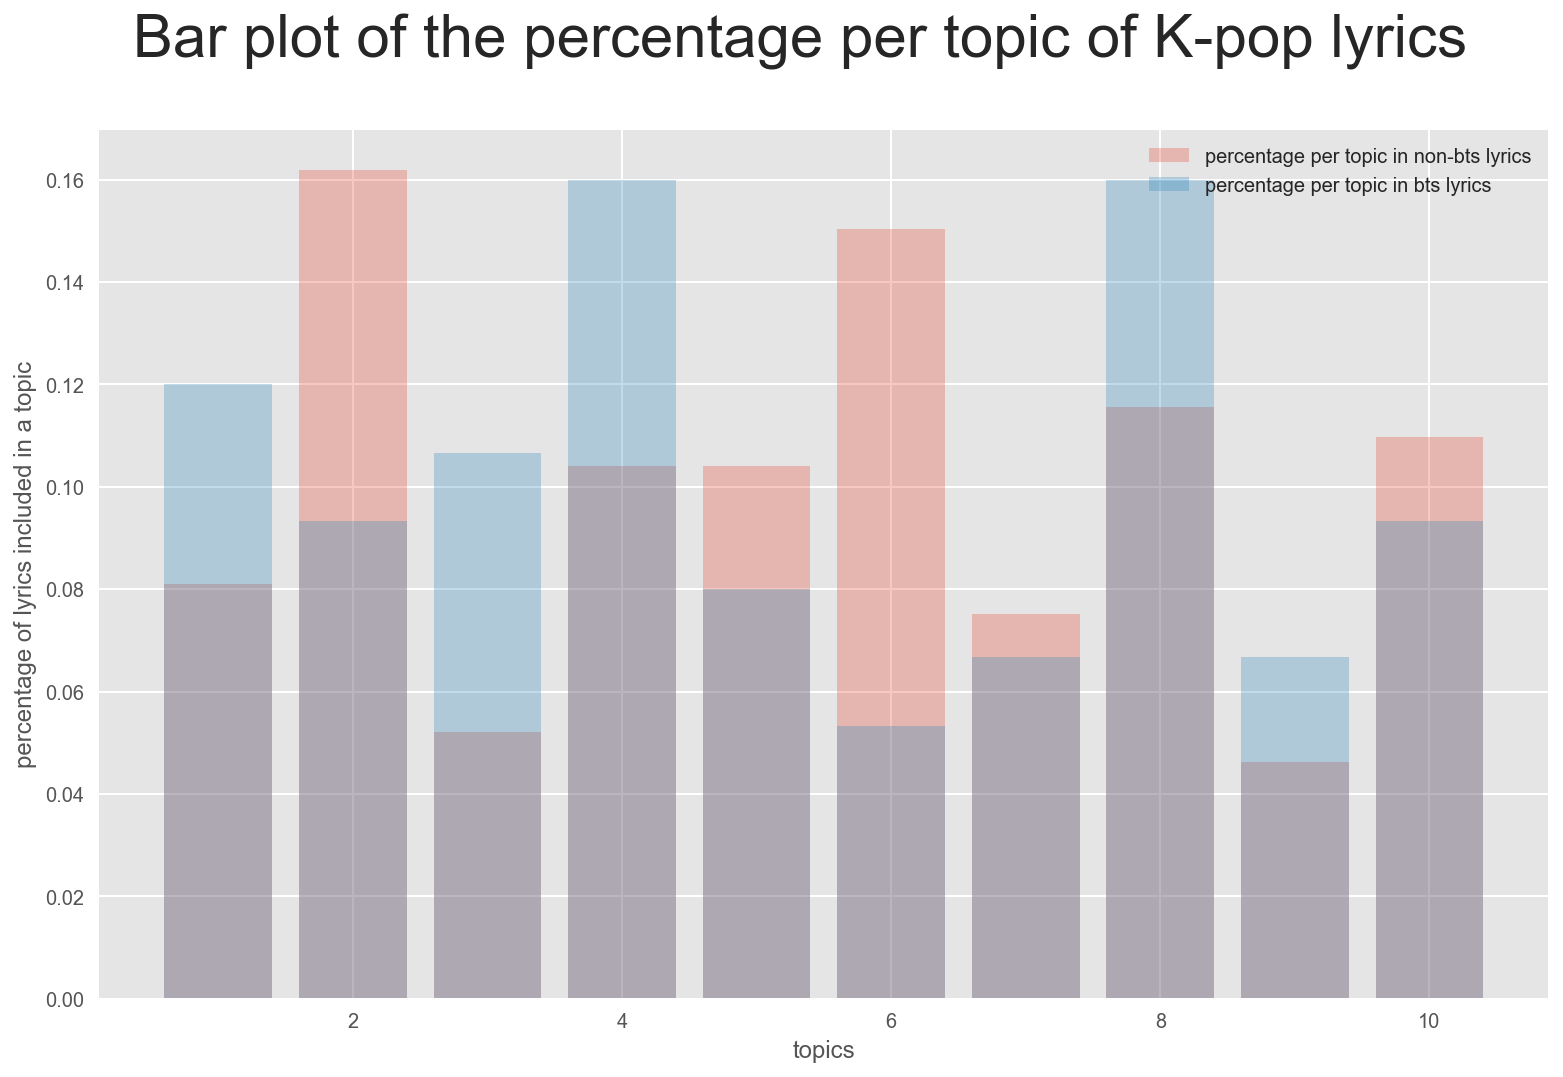

In [149]:
bar(non_bts_crosstab_normalized.index, non_bts_crosstab_normalized.values, alpha = 0.3, label = 'percentage per topic in non-bts lyrics');
bar(bts_crosstab_normalized.index, bts_crosstab_normalized.values, alpha= 0.3, label = 'percentage per topic in bts lyrics');
xlabel('topics')
ylabel('percentage of lyrics included in a topic')
legend()

suptitle('Bar plot of the percentage per topic of K-pop lyrics', size = 30);

>The barplot shows us here that there isn't much of huge difference between non-bts lyrics and bts lyrics in terms of thematic content. Non-bts lyrics do tend to embody topic 2, 5,6,10, but this doesn't tell us anything too conclusive. 